In [15]:
import os
import shutil

# List of gestures
gestures = ['open-hand', 'closed-fist', 'pointing']

# Delete existing images in each gesture folder
for gesture in gestures:
    folder_path = f"dataset/{gesture}"
    if os.path.exists(folder_path):
        # Delete the entire folder and its contents
        shutil.rmtree(folder_path)
        print(f"Deleted all images in {folder_path}")
    # Recreate the empty folder
    os.makedirs(folder_path, exist_ok=True)
    print(f"Created empty folder: {folder_path}")

Deleted all images in dataset/open-hand
Created empty folder: dataset/open-hand
Deleted all images in dataset/closed-fist
Created empty folder: dataset/closed-fist
Deleted all images in dataset/pointing
Created empty folder: dataset/pointing


In [16]:
import os

gestures = ['open-hand', 'closed-fist', 'pointing']
for gesture in gestures:
    num_images = len(os.listdir(f'dataset/{gesture}'))
    print(f"Number of images in {gesture}: {num_images}")

Number of images in open-hand: 0
Number of images in closed-fist: 0
Number of images in pointing: 0


In [17]:
import cv2
import os

# Function to capture images for a dataset
def capture_gesture_images(gesture_name, num_images=300, start_count=0):
    # Create directory for the gesture
    save_dir = f"dataset/{gesture_name}"
    
    # Check if save_dir exists as a file (not a directory)
    if os.path.exists(save_dir) and not os.path.isdir(save_dir):
        print(f"Error: '{save_dir}' exists as a file, not a directory. Deleting the file...")
        os.remove(save_dir)  # Delete the file
    os.makedirs(save_dir, exist_ok=True)  # Now create the directory
    
    # Open webcam
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return
    
    count = start_count
    
    print(f"\nCapturing images for gesture: {gesture_name}")
    print("Instructions:")
    if gesture_name == 'open-hand':
        print("- Hold your RIGHT hand with fingers spread, palm facing the camera (like a 'stop' sign).")
        print("- Keep your hand 30-50 cm from the camera, centered in the frame.")
    elif gesture_name == 'closed-fist':
        print("- Make a fist with your RIGHT hand (like you're about to punch).")
        print("- Knuckles should face the camera, 30-50 cm away, centered in the frame.")
    elif gesture_name == 'pointing':
        print("- Extend your RIGHT index finger to point, with other fingers folded down.")
        print("- Back of hand faces the camera, 30-50 cm away, centered in the frame.")
    print("- Slightly change the angle/position for each image (e.g., tilt left/right, move up/down).")
    print("- Use a PLAIN background (e.g., a solid wall) to reduce background noise.")
    print("Press 's' to save an image, 'Esc' to stop early.")
    
    while count < (start_count + num_images):
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame.")
            break
        
        # Display the frame
        cv2.imshow('Capture Gesture', frame)
        
        # Wait for key press
        key = cv2.waitKey(1)
        if key == ord('s'):  # Press 's' to save the image
            cv2.imwrite(f"{save_dir}/img_{count}.jpg", frame)
            print(f"Saved {save_dir}/img_{count}.jpg")
            count += 1
            print("Now slightly adjust your hand (e.g., tilt, move up/down) and press 's' again.")
        elif key == 27:  # Press 'Esc' to stop early
            break
    
    # Release resources
    cap.release()
    cv2.destroyAllWindows()
    print(f"Finished capturing {count - start_count} images for {gesture_name}")

# List of gestures to capture
gestures = ['open-hand', 'closed-fist', 'pointing']

# Capture 300 images for each gesture
for gesture in gestures:
    print(f"\nGet ready to capture 300 images for: {gesture}")
    print("Ensure your room is well-lit (bright, even light, no shadows).")
    print("Use a PLAIN background (e.g., a solid wall) to reduce background noise.")
    input("Press Enter to start capturing (make sure your RIGHT hand is ready)...")
    capture_gesture_images(gesture, num_images=300, start_count=0)


Get ready to capture 300 images for: open-hand
Ensure your room is well-lit (bright, even light, no shadows).
Use a PLAIN background (e.g., a solid wall) to reduce background noise.

Capturing images for gesture: open-hand
Instructions:
- Hold your RIGHT hand with fingers spread, palm facing the camera (like a 'stop' sign).
- Keep your hand 30-50 cm from the camera, centered in the frame.
- Slightly change the angle/position for each image (e.g., tilt left/right, move up/down).
- Use a PLAIN background (e.g., a solid wall) to reduce background noise.
Press 's' to save an image, 'Esc' to stop early.
Saved dataset/open-hand/img_0.jpg
Now slightly adjust your hand (e.g., tilt, move up/down) and press 's' again.
Saved dataset/open-hand/img_1.jpg
Now slightly adjust your hand (e.g., tilt, move up/down) and press 's' again.
Saved dataset/open-hand/img_2.jpg
Now slightly adjust your hand (e.g., tilt, move up/down) and press 's' again.
Saved dataset/open-hand/img_3.jpg
Now slightly adjust you

In [18]:
import os

gestures = ['open-hand', 'closed-fist', 'pointing']
for gesture in gestures:
    num_images = len(os.listdir(f'dataset/{gesture}'))
    print(f"Number of images in {gesture}: {num_images}")

Number of images in open-hand: 300
Number of images in closed-fist: 300
Number of images in pointing: 300


Found 720 images belonging to 3 classes.
Found 180 images belonging to 3 classes.

Training with learning rate: 0.0001


c:\Users\Adyasis\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Adyasis\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 304ms/step - accuracy: 0.3348 - loss: 1.0980 - val_accuracy: 0.4278 - val_loss: 1.0830
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.4562 - loss: 1.0769 - val_accuracy: 0.4778 - val_loss: 1.0604
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.4935 - loss: 1.0517 - val_accuracy: 0.7389 - val_loss: 1.0165
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.5680 - loss: 1.0066 - val_accuracy: 0.7278 - val_loss: 0.9411
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - accuracy: 0.6671 - loss: 0.9322 - val_accuracy: 0.6611 - val_loss: 0.8537
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.7241 - loss: 0.7930 - val_accuracy: 0.7889 - val_loss: 0.6733
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - accuracy: 0.8133 - loss: 0.6356 - val_accuracy: 0.7944 - val_loss: 0.5730
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - accuracy: 0.8627 - loss: 0.4869 - val_accuracy: 0

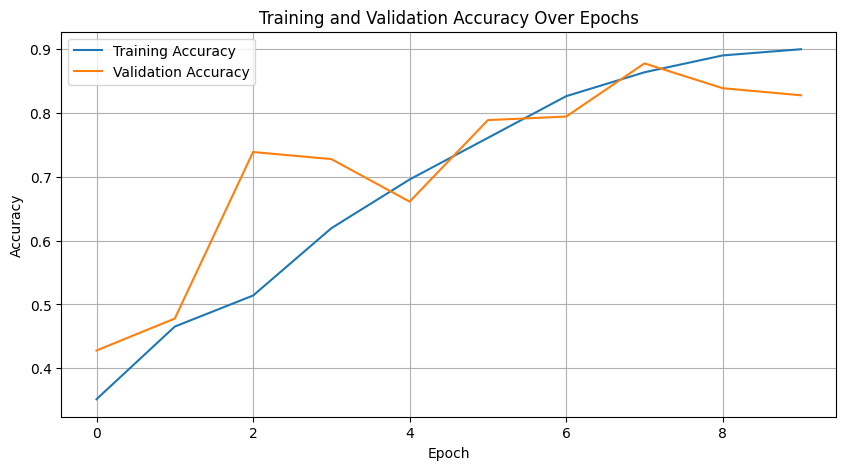

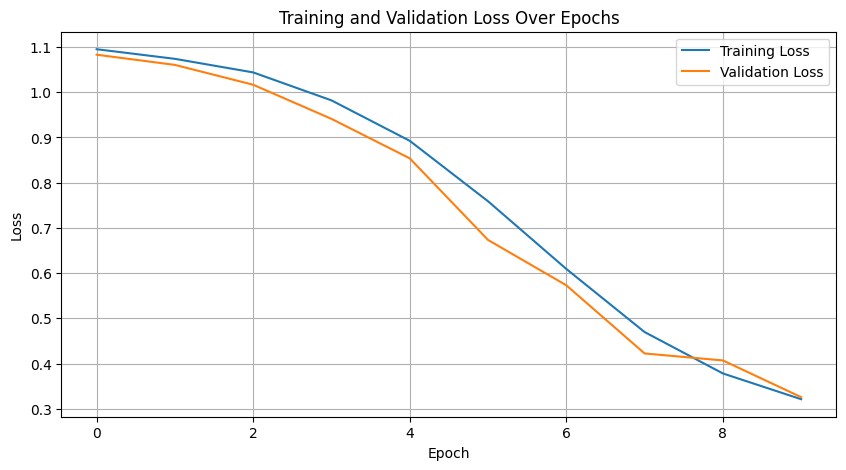

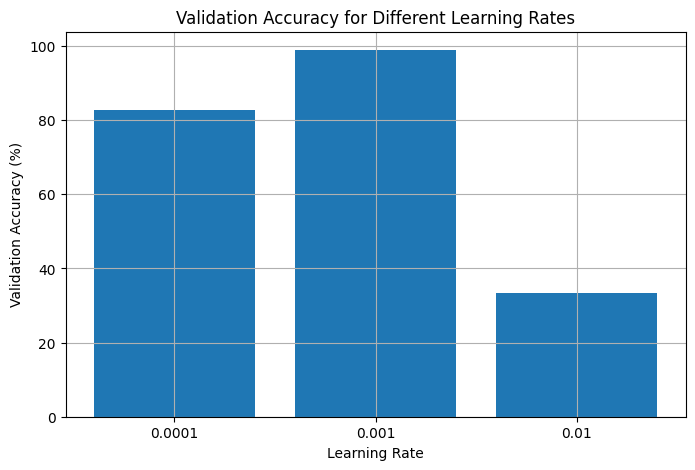

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


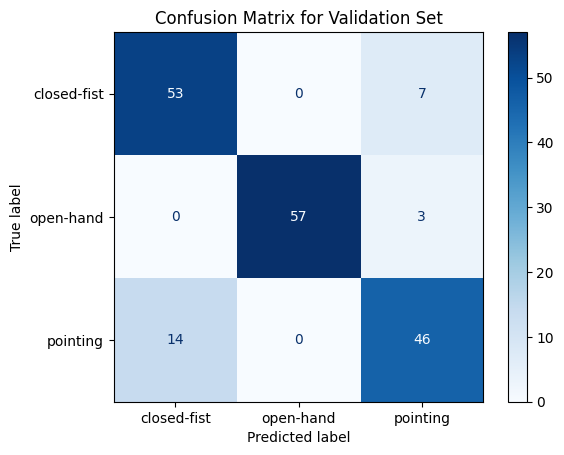


Training history for the best model:
Epoch 1: Training Accuracy: 35.14%, Validation Accuracy: 42.78%, Training Loss: 1.0951, Validation Loss: 1.0830
Epoch 2: Training Accuracy: 46.53%, Validation Accuracy: 47.78%, Training Loss: 1.0738, Validation Loss: 1.0604
Epoch 3: Training Accuracy: 51.39%, Validation Accuracy: 73.89%, Training Loss: 1.0438, Validation Loss: 1.0165
Epoch 4: Training Accuracy: 61.94%, Validation Accuracy: 72.78%, Training Loss: 0.9820, Validation Loss: 0.9411
Epoch 5: Training Accuracy: 69.58%, Validation Accuracy: 66.11%, Training Loss: 0.8925, Validation Loss: 0.8537
Epoch 6: Training Accuracy: 76.11%, Validation Accuracy: 78.89%, Training Loss: 0.7588, Validation Loss: 0.6733
Epoch 7: Training Accuracy: 82.64%, Validation Accuracy: 79.44%, Training Loss: 0.6091, Validation Loss: 0.5730
Epoch 8: Training Accuracy: 86.39%, Validation Accuracy: 87.78%, Training Loss: 0.4696, Validation Loss: 0.4222
Epoch 9: Training Accuracy: 89.03%, Validation Accuracy: 83.89%, T

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define paths to your dataset
dataset_dir = 'dataset'  # Path to your dataset folder
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32

# Data augmentation with increased intensity to add variability
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,           # Increased to 15° to add more variability
    width_shift_range=0.15,      # Increased to 15%
    height_shift_range=0.15,     # Increased to 15%
    shear_range=0.15,            # Increased to 15%
    zoom_range=0.15,             # Increased to 15%
    horizontal_flip=True,
    brightness_range=[0.7, 1.3], # Added brightness adjustment (70% to 130%)
    fill_mode='nearest',
    validation_split=0.2         # 80/20 train/validation split
)

# Load training and validation data
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # Important for confusion matrix: keep order for true labels
)

# Define the CNN model with increased dropout
def create_model(learning_rate=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Increased dropout to 0.5 to reduce overfitting
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Hyperparameter tuning: Try different learning rates
learning_rates = [0.0001, 0.001, 0.01]
best_val_accuracy = 0
best_learning_rate = 0
best_model = None
best_history = None
val_accuracies = []  # Store validation accuracies for comparison

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    model = create_model(learning_rate=lr)
    
    # Train the model for fewer epochs to prevent overfitting
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=10,  # Reduced from 20 to 10
        validation_data=val_generator,
        validation_steps=len(val_generator)
    )
    
    # Get the final validation accuracy
    val_accuracy = history.history['val_accuracy'][-1]
    val_accuracies.append(val_accuracy)
    print(f"Validation accuracy with learning rate {lr}: {val_accuracy * 100:.2f}%")
    
    # Save the best model (based on validation accuracy in the 80–90% range)
    if 0.80 <= val_accuracy <= 0.90 and val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_learning_rate = lr
        best_model = model
        best_history = history.history

# Save the best model
if best_model is not None:
    best_model.save('gesture_model_tuned.keras')
    print(f"\nBest model saved with learning rate {best_learning_rate} and validation accuracy {best_val_accuracy * 100:.2f}%")
else:
    print("\nNo model achieved validation accuracy in the 80–90% range. Try adjusting hyperparameters further.")
    # If no model is in the 80–90% range, we'll use the last model for plotting and confusion matrix
    best_history = history.history
    best_model = model
    best_learning_rate = lr
    best_val_accuracy = val_accuracy

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(best_history['accuracy'], label='Training Accuracy')
plt.plot(best_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(best_history['loss'], label='Training Loss')
plt.plot(best_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation accuracy for different learning rates
plt.figure(figsize=(8, 5))
plt.bar([str(lr) for lr in learning_rates], [acc * 100 for acc in val_accuracies])
plt.title('Validation Accuracy for Different Learning Rates')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy (%)')
plt.grid(True)
plt.show()

# Compute and plot the confusion matrix
# Get true labels and predictions for the validation set
val_generator.reset()  # Reset the generator to start from the beginning
predictions = best_model.predict(val_generator, steps=len(val_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())  # ['closed-fist', 'open-hand', 'pointing']

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Validation Set')
plt.show()

# Print training history for the best model
print("\nTraining history for the best model:")
for epoch in range(len(best_history['accuracy'])):
    print(f"Epoch {epoch + 1}: Training Accuracy: {best_history['accuracy'][epoch] * 100:.2f}%, Validation Accuracy: {best_history['val_accuracy'][epoch] * 100:.2f}%, Training Loss: {best_history['loss'][epoch]:.4f}, Validation Loss: {best_history['val_loss'][epoch]:.4f}")

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# # Build the CNN model
# model = Sequential([
#     # First convolutional layer
#     Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
#     MaxPooling2D((2, 2)),
    
#     # Second convolutional layer
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
    
#     # Third convolutional layer
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
    
#     # Flatten the output for the dense layers
#     Flatten(),
    
#     # Dense layers
#     Dense(128, activation='relu'),
#     Dropout(0.5),  # Add dropout to prevent overfitting
#     Dense(3, activation='softmax')  # 3 classes (open-hand, closed-fist, pointing)
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Print the model summary
# model.summary()

c:\Users\Adyasis\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,587 (2.61 MB)

 Trainable params: 683,587 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # Train the model
# history = model.fit(
#     train_generator,
#     epochs=10,
#     validation_data=validation_generator
# )

# # Save the model
# model.save('gesture_model.h5')
# print("Model saved as 'gesture_model.h5'")

c:\Users\Adyasis\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.3628 - loss: 1.1295

c:\Users\Adyasis\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 794ms/step - accuracy: 0.3591 - loss: 1.1288 - val_accuracy: 0.3333 - val_loss: 1.0979
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - accuracy: 0.3781 - loss: 1.1011 - val_accuracy: 0.3333 - val_loss: 1.0963
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.3655 - loss: 1.0936 - val_accuracy: 0.3833 - val_loss: 1.0918
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.3840 - loss: 1.0917 - val_accuracy: 0.5667 - val_loss: 1.0882
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.3572 - loss: 1.0823 - val_accuracy: 0.5167 - val_loss: 1.0643
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.3337 - loss: 1.0887 - val_accuracy: 0.4833 - val_loss: 1.0651
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.5188 - loss: 1.0408 - val_accuracy: 0.3833 - val_loss: 1.0054
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.5781 - loss: 0.9601 - val_accuracy: 0.5333 - val_loss: 0.8773
Epo

Model saved as 'gesture_model.h5'


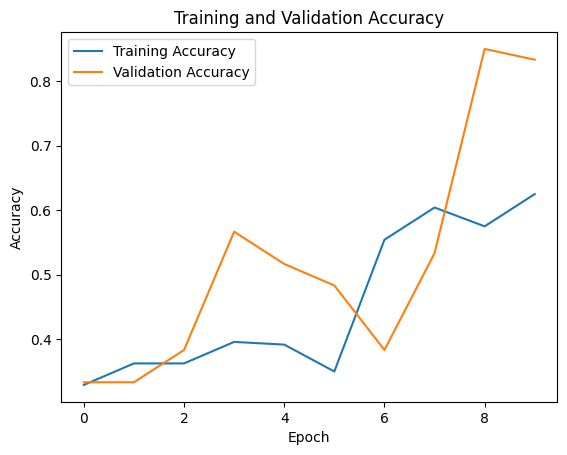

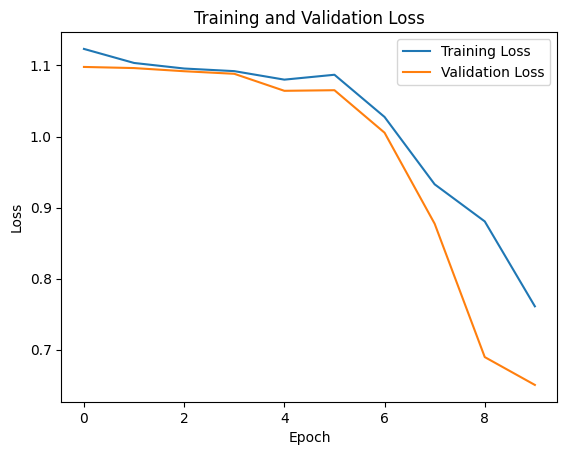

In [ ]:
# import matplotlib.pyplot as plt

# # Plot training and validation accuracy
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# # Plot training and validation loss
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [5]:
import cv2

# Capture a test image for open-hand
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open webcam.")
else:
    print("Press 's' to capture a test image, 'Esc' to exit.")
    print("Hold your right hand in the 'open-hand' gesture (fingers spread, palm facing camera).")
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame.")
            break
        # Define ROI (increased to 300x300 pixels in the center)
        height, width = frame.shape[:2]
        roi_size = 300  # Increased from 200 to 300
        roi_x = (width - roi_size) // 2
        roi_y = (height - roi_size) // 2
        # Draw ROI rectangle on the frame
        cv2.rectangle(frame, (roi_x, roi_y), (roi_x + roi_size, roi_y + roi_size), (0, 255, 0), 2)
        cv2.imshow('Capture Test Image', frame)
        key = cv2.waitKey(1)
        if key == ord('s'):
            # Crop the ROI from the frame
            roi = frame[roi_y:roi_y + roi_size, roi_x:roi_x + roi_size]
            cv2.imwrite('test_image_open_hand.jpg', roi)
            print("Test image saved as 'test_image_open_hand.jpg'")
            break
        elif key == 27:
            break
    cap.release()
    cv2.destroyAllWindows()

Press 's' to capture a test image, 'Esc' to exit.
Hold your right hand in the 'open-hand' gesture (fingers spread, palm facing camera).
Test image saved as 'test_image_open_hand.jpg'


In [6]:
import numpy as np
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('gesture_model_tuned.keras')

# Load and preprocess the test image
img = image.load_img('test_image_open_hand.jpg', target_size=(64, 64))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Predict the gesture
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)[0]

# Map the predicted class to the gesture name
class_indices = {'closed-fist': 0, 'open-hand': 1, 'pointing': 2}
gesture_names = {v: k for k, v in class_indices.items()}
predicted_gesture = gesture_names[predicted_class]

# Print the results
confidence = prediction[0][predicted_class]
print(f"Predicted gesture: {predicted_gesture} with confidence {confidence:.2%}")
print(f"Prediction probabilities: {prediction[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Predicted gesture: open-hand with confidence 94.21%
Prediction probabilities: [0.03510495 0.94207436 0.02282068]


In [22]:
import cv2

# Capture a test image for closed-fist
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open webcam.")
else:
    print("Press 's' to capture a test image, 'Esc' to exit.")
    print("Hold your right hand in the 'closed-fist' gesture (fingers curled, palm facing camera).")
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame.")
            break
        # Define ROI (300x300 pixels in the center)
        height, width = frame.shape[:2]
        roi_size = 300
        roi_x = (width - roi_size) // 2
        roi_y = (height - roi_size) // 2
        # Draw ROI rectangle on the frame
        cv2.rectangle(frame, (roi_x, roi_y), (roi_x + roi_size, roi_y + roi_size), (0, 255, 0), 2)
        cv2.imshow('Capture Test Image', frame)
        key = cv2.waitKey(1)
        if key == ord('s'):
            # Crop the ROI from the frame
            roi = frame[roi_y:roi_y + roi_size, roi_x:roi_x + roi_size]
            cv2.imwrite('test_image_closed_fist.jpg', roi)
            print("Test image saved as 'test_image_closed_fist.jpg'")
            break
        elif key == 27:
            break
    cap.release()
    cv2.destroyAllWindows()

Press 's' to capture a test image, 'Esc' to exit.
Hold your right hand in the 'closed-fist' gesture (fingers curled, palm facing camera).
Test image saved as 'test_image_closed_fist.jpg'


In [23]:
import numpy as np
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('gesture_model_tuned.keras')

# Load and preprocess the test image
img = image.load_img('test_image_closed_fist.jpg', target_size=(64, 64))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Predict the gesture
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)[0]

# Map the predicted class to the gesture name
class_indices = {'closed-fist': 0, 'open-hand': 1, 'pointing': 2}
gesture_names = {v: k for k, v in class_indices.items()}
predicted_gesture = gesture_names[predicted_class]

# Print the results
confidence = prediction[0][predicted_class]
print(f"Predicted gesture: {predicted_gesture} with confidence {confidence:.2%}")
print(f"Prediction probabilities: {prediction[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Predicted gesture: open-hand with confidence 69.62%
Prediction probabilities: [0.22953235 0.6962236  0.07424408]


In [26]:
import cv2

# Capture a test image for pointing
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open webcam.")
else:
    print("Press 's' to capture a test image, 'Esc' to exit.")
    print("Hold your right hand in the 'pointing' gesture (index finger extended, others folded, pointing at camera).")
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame.")
            break
        # Define ROI (300x300 pixels in the center)
        height, width = frame.shape[:2]
        roi_size = 300
        roi_x = (width - roi_size) // 2
        roi_y = (height - roi_size) // 2
        # Draw ROI rectangle on the frame
        cv2.rectangle(frame, (roi_x, roi_y), (roi_x + roi_size, roi_y + roi_size), (0, 255, 0), 2)
        cv2.imshow('Capture Test Image', frame)
        key = cv2.waitKey(1)
        if key == ord('s'):
            # Crop the ROI from the frame
            roi = frame[roi_y:roi_y + roi_size, roi_x:roi_x + roi_size]
            cv2.imwrite('test_image_pointing.jpg', roi)
            print("Test image saved as 'test_image_pointing.jpg'")
            break
        elif key == 27:
            break
    cap.release()
    cv2.destroyAllWindows()

Press 's' to capture a test image, 'Esc' to exit.
Hold your right hand in the 'pointing' gesture (index finger extended, others folded, pointing at camera).
Test image saved as 'test_image_pointing.jpg'


In [27]:
import numpy as np
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('gesture_model_tuned.keras')

# Load and preprocess the test image
img = image.load_img('test_image_pointing.jpg', target_size=(64, 64))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Predict the gesture
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)[0]

# Map the predicted class to the gesture name
class_indices = {'closed-fist': 0, 'open-hand': 1, 'pointing': 2}
gesture_names = {v: k for k, v in class_indices.items()}
predicted_gesture = gesture_names[predicted_class]

# Print the results
confidence = prediction[0][predicted_class]
print(f"Predicted gesture: {predicted_gesture} with confidence {confidence:.2%}")
print(f"Prediction probabilities: {prediction[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Predicted gesture: open-hand with confidence 64.94%
Prediction probabilities: [0.15945706 0.6493771  0.19116582]


In [28]:
import os
print(os.path.exists('gesture_model_tuned.keras'))

True


In [ ]:
#importing computer vision and numpy
import cv2
import numpy as np
import mediapipe as mp
from math import hypot
import screen_brightness_control as sbc
from pycaw.pycaw import AudioUtilities, IAudioEndpointVolume
from ctypes import cast, POINTER
from comtypes import CLSCTX_ALL
import time

In [6]:
def main():
    devices = AudioUtilities.GetSpeakers()
    interface = devices.Activate(IAudioEndpointVolume._iid_, CLSCTX_ALL, None)
    volume = cast(interface, POINTER(IAudioEndpointVolume))
    volRange = volume.GetVolumeRange()
    minVol, maxVol, _ = volRange

    mpHands = mp.solutions.hands
    hands = mpHands.Hands(static_image_mode=False, max_num_hands=2, model_complexity=1, min_detection_confidence=0.5, min_tracking_confidence=0.5)
    draw = mp.solutions.drawing_utils
    
    cap = cv2.VideoCapture(0)
    
    frame_count = 0
    detection_count = 0
    brightness_values = []  # For stability
    distance_values = []   # For precision
    
    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame_count += 1
            
            frame = cv2.flip(frame, 1)
            frameRGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            processed = hands.process(frameRGB)
            
            if processed.multi_hand_landmarks:
                detection_count += 1
                print(f"Hands detected! Frame: {frame_count}, Detection: {detection_count}")
            else:
                print(f"No hands detected. Frame: {frame_count}, Detection: {detection_count}")
            
            left_landmark_list, right_landmark_list = get_left_right_landmarks(frame, processed, draw, mpHands)

            # Brightness control with latency, stability, and precision
            if left_landmark_list:
                start_time = time.time()
                left_distance = get_distance(frame, left_landmark_list)
                b_level = np.interp(left_distance, [50,220], [0,100])
                sbc.set_brightness(b_level)
                end_time = time.time()
                latency_ms = (end_time - start_time) * 1000
                print(f"Brightness Latency: {latency_ms:.2f} ms")
                
                # Stability
                brightness_values.append(b_level)
                if len(brightness_values) > 100:
                    stability = np.std(brightness_values[-100:])
                    print(f"Brightness Stability (std dev): {stability:.2f}%")
                
                # Precision
                distance_values.append(left_distance)
                if len(distance_values) > 100:
                    avg_distance = np.mean(distance_values[-100:])
                    distance_std = np.std(distance_values[-100:])
                    print(f"Precision - Avg Distance: {avg_distance:.2f} px, Std Dev: {distance_std:.2f} px")
            
            # Volume control
            if right_landmark_list:
                right_distance = get_distance(frame, right_landmark_list)
                vol = np.interp(right_distance, [50,220], [minVol,maxVol])
                volume.SetMasterVolumeLevel(vol, None)
            
            # Detection accuracy: Print every 10 frames instead of 30
            accuracy = (detection_count / frame_count * 100) if frame_count > 0 else 0
            if frame_count % 10 == 0:  # Changed from 30 to 10
                print(f"Detection Accuracy: {accuracy:.2f}% (Frames: {frame_count}, Detections: {detection_count})")
            
            cv2.imshow('frame', frame)
            if cv2.waitKey(1) & 0xFF == 27:
                break
    finally:
        cap.release()
        cv2.destroyAllWindows()

def get_left_right_landmarks(frame, processed, draw, hands):
    left_landmarks_list = []
    right_landmarks_list = []

    if processed.multi_hand_landmarks:
        for handlm in processed.multi_hand_landmarks:
            for idx, found_landmark in enumerate(handlm.landmark):
                height, width, _ = frame.shape
                x, y = int(found_landmark.x*width), int(found_landmark.y*height)

                if idx == 4 or idx == 8:
                    landmark = [idx, x, y]
                    if handlm == processed.multi_hand_landmarks[0]:
                        left_landmarks_list.append(landmark)
                    elif handlm == processed.multi_hand_landmarks[1]:
                        right_landmarks_list.append(landmark)
            draw.draw_landmarks(frame, handlm, hands.HAND_CONNECTIONS)
    
    return left_landmarks_list, right_landmarks_list

def get_distance(frame, landmark_list):
    if len(landmark_list) < 2:
        return 

    (x1, y1), (x2, y2) = (landmark_list[0][1], landmark_list[0][2]), \
        (landmark_list[1][1], landmark_list[1][2])

    cv2.circle(frame, (x1, y1), 7, (0,255,0), cv2.FILLED)
    cv2.circle(frame, (x2, y2), 7, (0,255,0), cv2.FILLED)
    cv2.line(frame, (x1, y1), (x2, y2), (0,255,0), 3)

    L = hypot(x2-x1, y2-y1)
    return L

In [ ]:
if __name__ == '__main__':
    main();

No hands detected. Frame: 1, Detection: 0
No hands detected. Frame: 2, Detection: 0
No hands detected. Frame: 3, Detection: 0
No hands detected. Frame: 4, Detection: 0
No hands detected. Frame: 5, Detection: 0
No hands detected. Frame: 6, Detection: 0
No hands detected. Frame: 7, Detection: 0
No hands detected. Frame: 8, Detection: 0
No hands detected. Frame: 9, Detection: 0
No hands detected. Frame: 10, Detection: 0
Detection Accuracy: 0.00% (Frames: 10, Detections: 0)
No hands detected. Frame: 11, Detection: 0
No hands detected. Frame: 12, Detection: 0
No hands detected. Frame: 13, Detection: 0
No hands detected. Frame: 14, Detection: 0
No hands detected. Frame: 15, Detection: 0
No hands detected. Frame: 16, Detection: 0
No hands detected. Frame: 17, Detection: 0
No hands detected. Frame: 18, Detection: 0
No hands detected. Frame: 19, Detection: 0
No hands detected. Frame: 20, Detection: 0
Detection Accuracy: 0.00% (Frames: 20, Detections: 0)
No hands detected. Frame: 21, Detection: 